In [14]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import pickle

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32,16)
        )

        self.decoder = nn.Sequential(
            nn.Linear(16,32),
            nn.ReLU(),
            nn.Linear(32,64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [6]:
with open('../data/splits.pkl', 'rb') as f:
    splits = pickle.load(f)

x_train = splits['X_train']
x_test = splits['X_test']

In [7]:
input_dim = x_train.shape[1]

# Re-create model architecture
model = Autoencoder(input_dim)

# Load trained weights
model.load_state_dict(torch.load('../data/autoencoder_model.pth'))

# Set to eval mode
model.eval()


C:\Users\apara\AppData\Local\Temp\ipykernel_13248\3643936318.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../data/autoencoder_model.

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=30, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=30, bias=True)
  )
)

In [ ]:
# Convert to torch tensor
x_test_tensor = torch.tensor(x_test.values).float()

# Batch loader (For larger test sets)
test_loader = torch.utils.data.DataLoader(x_test_tensor, batch_size=64, shuffle=False)

In [9]:
anomaly_scores = []

with torch.no_grad():
    for batch in test_loader:
        outputs = model(batch)
        mse = torch.mean((outputs - batch)**2, dim = 1)
        anomaly_scores.append(mse.numpy())


anomaly_scores = np.concatenate(anomaly_scores)

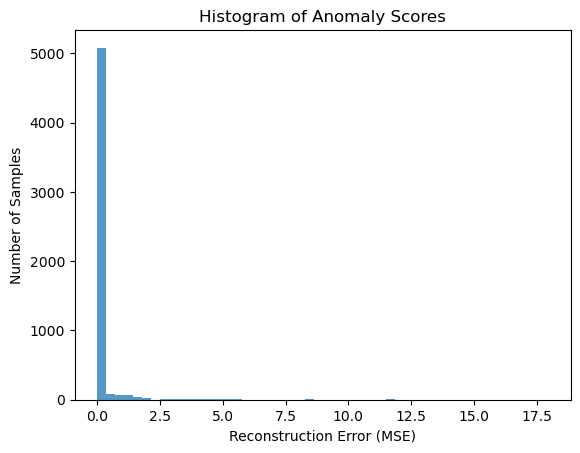

In [10]:
plt.hist(anomaly_scores, bins=50, alpha=0.75)
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Number of Samples')
plt.title('Histogram of Anomaly Scores')
plt.show()

In [11]:
y_test = splits['Y_test']
y_test = np.array(y_test)

In [16]:
thresholds = np.linspace(min(anomaly_scores), max(anomaly_scores), 100)

precision_list = []
recall_list = []
f1_list = []
valid_thresholds = []

for thresh in thresholds:
    preds = (anomaly_scores > thresh).astype(int)

    if preds.sum() == 0: # Skip thresholds where model predicts no anomalies
        continue

    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    valid_thresholds.append(thresh)

In [17]:
plt.plot(valid_thresholds, precision_list, label = 'Precision')
plt.plot(valid_thresholds, recall_list, label = 'recall')
plt.plot(valid_thresholds, f1_list, label = 'f1 Score')
plt.xlabel('Thresholds')
plt.ylabel('Score')
plt.title('Precision, Recall, F1 vs. Threshold')
plt.legend()
plt.savefig('../plots/threshold_precisionRecallF1_curve.png')
plt.close('all')

In [ ]:
# Convert lists to numpy arrays
precision_array = np.array(precision_list)
recall_array = np.array(recall_list)
f1_array = np.array(f1_list)
valid_thresholds = np.array(valid_thresholds)

best_idx = np.argmax(f1_array)
best_threshold = valid_thresholds[best_idx]
best_f1 = f1_array[best_idx]
best_precision = precision_array[best_idx]
best_recall = recall_array[best_idx]

print("==== Best Threshold Results ====")
print(f"Best threshold: {best_threshold:.5f}")
print(f"F1 Score    : {best_f1:.4f}")
print(f"Precision   : {best_precision:.4f}")
print(f"Recall      : {best_recall:.4f}")

==== Best Threshold Results ====
Best threshold: 0.36308
F1 Score    : 0.8549
Precision   : 0.9392
Recall      : 0.7846


In [21]:
with open('../data/best_threshold.pkl', 'wb') as f:
    pickle.dump(best_threshold, f)